In [1]:
import os
import sys
import pandas as pd, geopandas as gp, matplotlib.pyplot as plt, numpy as np
import getpass
import requests 
import json
import contextily as ctx
from pandas import ExcelWriter
import censusdata

# user = getpass.getuser()
# sys.dont_write_bytecode = True
# sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

# from utils_io import *

### Read census api key from file

In [2]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [14]:
def flag_condition_calc(row, df_share_column, standard_deviation):
    cond = (
        df_share_column.mean().round(decimals=2)
        + (standard_deviation * df_share_column.std().round(decimals=2))
    ).round(decimals=2)
    if row > cond:
        return 1
    else:
        return 0

In [15]:
def flag_mult_columns(dataframe, dictionary, standard_deviation):
    for key, value in dictionary.items():
        dataframe[value] = dataframe[key].apply(
            lambda row: flag_condition_calc(row, acs_df[key], standard_deviation)
        )

In [35]:
def set_coc_class(df):
    if df["coc50_1ha"] == 1:
        return "Highest"
    elif df["coc50_1"] == 1:
        return "Higher"
    elif df["coc50_1_2"] == 1:
        return "High"
    else:
        return "NA"

### Read selected ACS varibles from csv

In [3]:
acs_coc_selected_vars = pd.read_csv('Data/ACS_Table_Variables_COC_Factors.csv')

In [4]:
acs_vars_lst = acs_coc_selected_vars['ACS_Table_Variable'].tolist()

### Query ACS API
#### [Census American Community Survey 5-Year Data API Documentation](https://www.census.gov/data/developers/data-sets/acs-5year.html)

In [5]:
api_file = 'census_api_key.txt'

api_key = get_file_contents(api_file)

In [6]:
var = ','.join(acs_vars_lst)
counties = '001,013,041,055,075,081,085,095,097'
state = '06'
url = f"https://api.census.gov/data/2018/acs/acs5?get={var}&for=tract:*&in=county:{counties}&in=state:{state}&key={api_key}"
rq = requests.get(url)
data = rq.json()
acs_df = pd.DataFrame(data[1:],columns=data[0])

In [7]:
acs_df['county'].unique()

array(['055', '085', '095', '075', '013', '081', '001', '097', '041'],
      dtype=object)

### Change data type to integer select columns

In [8]:
acs_df[acs_vars_lst] = acs_df[acs_vars_lst].apply(pd.to_numeric)

In [9]:
acs_df['geoid'] = acs_df['state'] + acs_df['county'] + acs_df['tract']

### Rename columns for consistancy with prior CoCs

In [10]:
cols = {
    "county": "county_fip",
    "B03002_001E": "tot_pop_mi",
    "B01001_001E": "tot_pop_se",
    "C17002_001E": "tot_pop_po",
    "C18108_001E": "tot_pop_ci",
    "B08201_001E": "tot_hh",
    "B11004_001E": "tot_fam",
    "B16005_001E": "tot_pop_ov",
    "B25070_010E": "pop_hus_re",
    "B08201_002E": "pop_zvhhs",
}
acs_df.rename(columns=cols, inplace=True)

### Calculate CoC and populations

In [11]:
acs_df["pop_minori"] = acs_df["tot_pop_mi"] - acs_df["B03002_003E"]
acs_df["pop_over75"] = (
    acs_df["B01001_023E"]
    + acs_df["B01001_024E"]
    + acs_df["B01001_025E"]
    + acs_df["B01001_047E"]
    + acs_df["B01001_048E"]
    + acs_df["B01001_049E"]
)
acs_df["pop_spfam"] = acs_df["B11004_010E"] + acs_df["B11004_016E"]
acs_df["pop_lep"] = (
    acs_df["B16005_007E"]
    + acs_df["B16005_008E"]
    + acs_df["B16005_012E"]
    + acs_df["B16005_013E"]
    + acs_df["B16005_017E"]
    + acs_df["B16005_018E"]
    + acs_df["B16005_022E"]
    + acs_df["B16005_023E"]
    + acs_df["B16005_029E"]
    + acs_df["B16005_030E"]
    + acs_df["B16005_034E"]
    + acs_df["B16005_035E"]
    + acs_df["B16005_039E"]
    + acs_df["B16005_040E"]
    + acs_df["B16005_044E"]
    + acs_df["B16005_045E"]
)
acs_df["pop_below2"] = acs_df["tot_pop_po"] - acs_df["C17002_008E"]
acs_df["pop_disabi"] = acs_df["tot_pop_ci"] - (
    acs_df["C18108_005E"] + acs_df["C18108_009E"] + acs_df["C18108_013E"]
)

### Calculate CoC shares

In [12]:
acs_df["pct_minori"] = np.where(
    acs_df["tot_pop_mi"] == 0, 0, (acs_df["pop_minori"] / acs_df["tot_pop_mi"])
)
acs_df["pct_over75"] = np.where(
    acs_df["tot_pop_se"] == 0, 0, (acs_df["pop_over75"] / acs_df["tot_pop_se"])
)
acs_df["pct_spfam"] = np.where(acs_df["tot_fam"] == 0, 0, (acs_df["pop_spfam"] / acs_df["tot_fam"]))
acs_df["pct_lep"] = np.where(
    acs_df["tot_pop_ov"] == 0, 0, (acs_df["pop_lep"] / acs_df["tot_pop_ov"])
)
acs_df["pct_below2"] = np.where(
    acs_df["tot_pop_po"] == 0, 0, (acs_df["pop_below2"] / acs_df["tot_pop_po"])
)
acs_df["pct_disab"] = np.where(
    acs_df["tot_pop_ci"] == 0, 0, (acs_df["pop_disabi"] / acs_df["tot_pop_ci"])
)
acs_df["pct_zvhhs"] = np.where(acs_df["tot_hh"] == 0, 0, (acs_df["pop_zvhhs"] / acs_df["tot_hh"]))
acs_df["pct_hus_re"] = np.where(acs_df["tot_hh"] == 0, 0, (acs_df["pop_hus_re"] / acs_df["tot_hh"]))

### Flag cocs and coc levels (high, higher, highest) 

### Flag halfsd columns and count factors

In [16]:
cols_dict_halfsd = {
    "pct_over75": "over75_1_2",
    "pct_minori": "minori_1_2",
    "pct_spfam": "spfam_1_2",
    "pct_disab": "disab_1_2",
    "pct_lep": "lep_1_2",
    "pct_below2": "below2_1_2",
    "pct_zvhhs": "zvhh_1_2",
    "pct_hus_re": "hus_re_1_2",
}

In [17]:
flag_mult_columns(acs_df,cols_dict_halfsd,.5)

In [18]:
halfsd_cols_list = [
    "below2_1_2",
    "minori_1_2",
    "spfam_1_2",
    "disab_1_2",
    "lep_1_2",
    "over75_1_2",
    "zvhh_1_2",
    "hus_re_1_2",
]
acs_df["count_1_2"] = acs_df[halfsd_cols_list].sum(axis=1)

In [19]:
acs_df[halfsd_cols_list][acs_df['count_1_2'] >= 1]

,below2_1_2,minori_1_2,spfam_1_2,disab_1_2,lep_1_2,over75_1_2,zvhh_1_2,hus_re_1_2
0,1,0,1,1,1,0,0,1
2,1,0,1,1,0,0,1,1
3,0,1,0,0,0,0,0,0
8,0,0,0,0,0,1,0,0
9,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...
1583,0,0,0,0,0,1,0,0
1584,0,0,0,0,0,1,0,0
1585,0,0,0,0,0,1,0,0
1586,0,0,1,1,1,1,0,0


### Flag halfsd coc

In [20]:
halfsd_remain = ["spfam_1_2", "disab_1_2", "lep_1_2", "over75_1_2", "zvhh_1_2", "hus_re_1_2"]
halfsd_cond = ((acs_df["minori_1_2"] == 1) & (acs_df["below2_1_2"] == 1)) | (
    (acs_df["below2_1_2"] == 1) & (acs_df[halfsd_remain].sum(axis=1) >= 3)
)
acs_df["coc50_1_2"] = np.where(halfsd_cond, 1, 0)

In [21]:
acs_df[halfsd_cols_list][acs_df['coc50_1_2'] == 1]

,below2_1_2,minori_1_2,spfam_1_2,disab_1_2,lep_1_2,over75_1_2,zvhh_1_2,hus_re_1_2
0,1,0,1,1,1,0,0,1
2,1,0,1,1,0,0,1,1
9,1,1,1,0,1,0,0,0
11,1,1,1,0,1,0,0,0
18,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
1543,1,1,1,0,0,0,0,1
1544,1,1,1,0,1,0,0,1
1549,1,1,1,1,1,0,0,1
1564,1,0,1,1,1,0,0,0


### Flag onesd columns

In [22]:
cols_dict_onesd = {
    "pct_over75": "over75_1",
    "pct_minori": "minori_1",
    "pct_spfam": "spfam_1",
    "pct_disab": "disab_1",
    "pct_lep": "lep_1",
    "pct_below2": "below2_1",
    "pct_zvhhs": "zvhh_1",
    "pct_hus_re": "hus_re_1",
}

In [23]:
flag_mult_columns(acs_df, cols_dict_onesd, 1)

In [24]:
onesd_cols_list = [
    "below2_1",
    "minori_1",
    "spfam_1",
    "disab_1",
    "lep_1",
    "over75_1",
    "zvhh_1",
    "hus_re_1",
]
acs_df["count_1"] = acs_df[onesd_cols_list].sum(axis=1)

### Flag onesd coc

In [25]:
onesd_remain = ["spfam_1", "disab_1", "lep_1", "over75_1", "zvhh_1", "hus_re_1"]
onesd_cond = ((acs_df["minori_1"] == 1) & (acs_df["below2_1"] == 1)) | (
    (acs_df["below2_1"] == 1) & (acs_df[onesd_remain].sum(axis=1) >= 3)
)
acs_df["coc50_1"] = np.where(onesd_cond, 1, 0)

In [26]:
acs_df[onesd_cols_list][(acs_df["coc50_1"] == 1)]

,below2_1,minori_1,spfam_1,disab_1,lep_1,over75_1,zvhh_1,hus_re_1
2,1,0,1,1,0,0,1,1
19,1,1,1,1,0,0,1,1
34,1,1,1,0,1,0,0,0
35,1,1,1,0,1,0,0,1
38,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1481,1,1,1,0,1,0,0,1
1506,1,1,1,0,1,0,0,1
1507,1,0,1,0,1,0,0,1
1527,1,0,1,0,1,0,0,1


### Flag onehalfsd columns

In [27]:
cols_dict_onehalfsd = {
    "pct_over75": "over75_1ha",
    "pct_minori": "minori_1ha",
    "pct_spfam": "spfam_1ha",
    "pct_disab": "disab_1ha",
    "pct_lep": "lep_1ha",
    "pct_below2": "below2_1ha",
    "pct_zvhhs": "zvhh_1ha",
    "pct_hus_re": "hus_re_1ha",
}

In [28]:
flag_mult_columns(acs_df,cols_dict_onehalfsd,1.5)

In [29]:
onehalfsd_cols_list = [
    "below2_1ha",
    "minori_1ha",
    "spfam_1ha",
    "disab_1ha",
    "lep_1ha",
    "over75_1ha",
    "zvhh_1ha",
    "hus_re_1ha",
]
acs_df["count_1ha"] = acs_df[onehalfsd_cols_list].sum(axis=1)

In [30]:
acs_df[onehalfsd_cols_list][acs_df["count_1ha"] >= 1]

,below2_1ha,minori_1ha,spfam_1ha,disab_1ha,lep_1ha,over75_1ha,zvhh_1ha,hus_re_1ha
0,0,0,1,0,0,0,0,0
2,1,0,1,1,0,0,1,1
9,0,0,0,0,1,0,0,0
10,0,0,0,0,1,0,0,0
11,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
1549,0,1,0,0,1,0,0,0
1550,0,1,1,0,0,0,0,0
1564,0,0,0,0,1,0,0,0
1575,0,0,0,0,1,0,0,0


### Flag onehalfsd coc

In [31]:
onehalfsd_remain = ["spfam_1ha", "disab_1ha", "lep_1ha", "over75_1ha", "zvhh_1ha", "hus_re_1ha"]
onehalfsd_cond = ((acs_df["minori_1ha"] == 1) & (acs_df["below2_1ha"] == 1)) | (
    (acs_df["below2_1ha"] == 1) & (acs_df[onehalfsd_remain].sum(axis=1) >= 3)
)
acs_df["coc50_1ha"] = np.where(onehalfsd_cond, 1, 0)

In [32]:
acs_df[onehalfsd_cols_list][(acs_df["coc50_1ha"] == 1)]

,below2_1ha,minori_1ha,spfam_1ha,disab_1ha,lep_1ha,over75_1ha,zvhh_1ha,hus_re_1ha
2,1,0,1,1,0,0,1,1
19,1,0,1,1,0,0,1,1
35,1,0,1,0,1,0,0,1
51,1,0,1,1,0,0,0,1
101,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...
1401,1,0,0,1,1,1,1,0
1460,1,1,0,0,1,1,1,1
1466,1,1,1,1,1,1,1,0
1506,1,1,1,0,1,0,0,1


### Flag 2050 cocs

In [33]:
acs_df["coc_2050"] = np.where(
    (acs_df["coc50_1ha"] == 1) | (acs_df["coc50_1"] == 1) | (acs_df["coc50_1_2"]), 1, 0
)

In [34]:
acs_df[["coc_2050", "coc50_1_2", "coc50_1", "coc50_1ha"]][acs_df["coc_2050"] == 1]

,coc_2050,coc50_1_2,coc50_1,coc50_1ha
0,1,1,0,0
2,1,1,1,1
9,1,1,0,0
11,1,1,0,0
18,1,1,0,0
...,...,...,...,...
1543,1,1,0,0
1544,1,1,0,0
1549,1,1,1,0
1564,1,1,0,0


### Create coc classes

In [36]:
acs_df["coc_class"] = acs_df.apply(set_coc_class, axis=1)

In [37]:
acs_df[acs_df["coc_class"] != "NA"]

,tot_pop_mi,B03002_003E,tot_pop_se,B01001_023E,B01001_024E,B01001_025E,B01001_047E,B01001_048E,B01001_049E,tot_pop_po,...,spfam_1ha,disab_1ha,lep_1ha,below2_1ha,zvhh_1ha,hus_re_1ha,count_1ha,coc50_1ha,coc_2050,coc_class
0,2772,1388,2772,23,9,10,77,8,8,2580,...,1,0,0,0,0,0,1,0,1,High
2,722,396,722,23,0,0,0,0,0,119,...,1,1,0,1,1,1,5,1,1,Highest
9,8414,524,8414,77,0,72,158,17,17,8368,...,0,0,1,0,0,0,1,0,1,High
11,4855,68,4855,27,19,40,41,23,21,4790,...,0,0,1,0,0,0,2,0,1,High
18,5571,1096,5571,29,30,9,75,0,22,5501,...,0,0,0,0,0,0,0,0,1,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5565,1643,5565,23,19,46,87,12,48,5553,...,0,0,0,0,0,0,0,0,1,High
1544,7820,2155,7820,62,51,24,42,89,105,7674,...,0,0,0,0,0,0,0,0,1,High
1549,4278,157,4278,64,29,25,79,40,63,4258,...,0,0,1,0,0,0,2,0,1,Higher
1564,5481,2238,5481,98,22,19,5,62,93,5436,...,0,0,1,0,0,0,1,0,1,High


In [38]:
acs_df.groupby("coc_class")["coc_2050"].agg(sum)

coc_class
High       156
Higher     105
Highest     78
NA           0
Name: coc_2050, dtype: int64

### Merge with PBA2040 CoC table

In [39]:
coc_pba2040 = pd.read_csv("Data/COCs_ACS2014_tbl.csv", dtype={"GEOID": str})

,OID,GEOID,TOT_POP,POP_MINORITY,POP_OVER75,POP_SPFAM,POP_LEP,POP_BELOW200,POP_DISABILITY,POP_HUS_RENT50,...,DISAB_25,LEP_20,LOWINC_30,ZVHH_10,RENT50OCCHUS_15,SUM_6,COCFLAG_2017,COCFLAG_2013,TOT_FAM,COUNTY_FIP
0,-1,06001400100,3385,1287,289,19,80,173,223,62,...,0,0,0,0,0,0,0,0,818,1.0
1,-1,06001400200,1939,549,131,15,0,161,143,16,...,0,0,0,0,0,0,0,0,479,1.0
2,-1,06001400300,5428,2092,347,65,131,781,408,181,...,0,0,0,1,0,1,0,0,1130,1.0
3,-1,06001400400,4279,1722,182,143,43,672,551,126,...,0,0,0,0,0,0,0,0,884,1.0
4,-1,06001400500,3516,1674,113,45,64,924,339,207,...,0,0,0,1,0,1,0,0,519,1.0
5,-1,06001400600,1750,1123,85,84,65,590,215,111,...,0,0,1,1,1,3,1,1,382,1.0
6,-1,06001400700,4396,2894,284,228,93,2129,792,440,...,0,0,1,1,1,3,1,1,915,1.0
7,-1,06001400800,3218,2052,129,82,34,870,384,231,...,0,0,0,1,0,1,0,0,630,1.0
8,-1,06001400900,2031,1052,26,160,21,528,228,154,...,0,0,0,0,1,2,0,0,445,1.0
9,-1,06001401000,5505,3946,306,342,213,2502,839,785,...,0,0,1,1,1,3,1,1,1069,1.0


In [40]:
coc_pba2040['COCFLAG_2013'].dtype

dtype('int64')

In [41]:
coc_pba2050_pba2040_compare = pd.merge(
    acs_df,
    coc_pba2040[["GEOID", "COCFLAG_2017", "COCFLAG_2013"]],
    left_on="geoid",
    right_on="GEOID",
    how="left",
)

In [43]:
coc_pba2050_pba2040_compare.rename(
    columns={"COCFLAG_2017": "coc_2040", "COCFLAG_2013": "coc_2035"}, inplace=True
)

In [44]:
coc_pba2050_pba2040_compare['coc_2035'].dtype

dtype('float64')

In [45]:
coc_pba2050_pba2040_compare["coc_2035"] = (
    coc_pba2050_pba2040_compare["coc_2035"].fillna(0.0).astype(int)
)

### Sum pba2050 and pba2040 cocs for comparison

In [46]:
coc_pba2050_pba2040_compare[["coc_2040", "coc_2050"]].sum()

coc_2040    365.0
coc_2050    339.0
dtype: float64

### Sum pba2040 cocs and ACS2016 cocs for a sanity check
#### - Appears that CoCs are decreasing in the region from the ACS2014 figures to the ACS2018 figures

In [47]:
coc_dif_acs2014_acs2016 = pd.read_csv("Data/COC_Diff_ACS2014_ACS2016.csv")
coc_dif_acs2014_acs2016.head(5)

,Unnamed: 0,GEOID,COCFLAG_2017,COC_FLAG_2018,Gain_Loss_2014_2016
0,1,6001400100,0,0.0,0.0
1,2,6001400200,0,0.0,0.0
2,3,6001400300,0,0.0,0.0
3,4,6001400400,0,0.0,0.0
4,5,6001400500,0,0.0,0.0


In [48]:
coc_dif_acs2014_acs2016[["COCFLAG_2017", "COC_FLAG_2018"]].sum()

COCFLAG_2017     365.0
COC_FLAG_2018    336.0
dtype: float64

### Calculate coc gains and losses by tract for pba2040 and pba2050

In [49]:
coc_pba2050_pba2040_compare["coc_2040"].fillna(0, inplace=True)
coc_pba2050_pba2040_compare["coc_2040"] = coc_pba2050_pba2040_compare["coc_2040"].astype(int)

In [50]:
coc_pba2050_pba2040_compare["c2040_2050"] = (
    coc_pba2050_pba2040_compare["coc_2050"] - coc_pba2050_pba2040_compare["coc_2040"]
)

In [51]:
print(
    "Between ACS2014 and ACS2018, COC tracts decreased by: "
    + coc_pba2050_pba2040_compare["c2040_2050"].sum().astype(str)
)

Between ACS2014 and ACS2018, COC tracts decreased by: -26


### Select subset of columns to export to csv

In [52]:
coc_select_cols = [
    "geoid",
    "state",
    "county_fip",
    "tract",
    "tot_pop_mi",
    "tot_pop_po",
    "tot_pop_ci",
    "tot_hh",
    "pop_zvhhs",
    "tot_fam",
    "tot_pop_ov",
    "pop_hus_re",
    "pop_minori",
    "pop_over75",
    "pop_spfam",
    "pop_lep",
    "pop_below2",
    "pop_disabi",
    "pct_minori",
    "pct_over75",
    "pct_spfam",
    "pct_lep",
    "pct_below2",
    "pct_disab",
    "pct_zvhhs",
    "pct_hus_re",
    "over75_1_2",
    "minori_1_2",
    "spfam_1_2",
    "disab_1_2",
    "lep_1_2",
    "below2_1_2",
    "zvhh_1_2",
    "hus_re_1_2",
    "coc_2035",
    "coc_2040",
    "coc_2050",
    "c2040_2050",
    "coc_class",
]

In [53]:
cocs_pba2050 = coc_pba2050_pba2040_compare[coc_select_cols].copy()

In [54]:
cocs_pba2050.rename(columns={"tot_pop_mi": "tot_pop"}, inplace=True)

In [56]:
cocs_pba2050.to_csv("Data/COCs_ACS2018_tbl.csv", index=False)

### Calculate regional statistics 

In [57]:
coc_region_stats = (
    acs_df.agg(
        {
            "pct_over75": ["mean", "std"],
            "pct_minori": ["mean", "std"],
            "pct_lep": ["mean", "std"],
            "pct_spfam": ["mean", "std"],
            "pct_below2": ["mean", "std"],
            "pct_disab": ["mean", "std"],
            "pct_zvhhs": ["mean", "std"],
            "pct_hus_re": ["mean", "std"],
        }
    )
    .transpose()
    .reset_index()
)

In [58]:
coc_region_stats.rename(columns={"index": "factors"}, inplace=True)

In [60]:
coc_factors = {
    "pct_over75": "Seniors 75 Years and Over",
    "pct_minori": "Minorities",
    "pct_lep": "Limited English Proficiency",
    "pct_spfam": "Single Parent Families",
    "pct_below2": "Low-Income (<200% Federal Poverty Level-FPL)",
    "pct_disab": "People with Disability",
    "pct_zvhhs": "Zero-Vehicle Household",
    "pct_hus_re": "Rent-Burdened",
}
coc_region_stats["factors"].replace(coc_factors, inplace=True)

In [61]:
coc_region_stats["mean"] = coc_region_stats["mean"].round(decimals=2)
coc_region_stats["std"] = coc_region_stats["std"].round(decimals=2)

### Create fields for .5, 1, and 1.5 sd from mean

In [62]:
coc_region_stats["plus_half_sd"] = (
    coc_region_stats["mean"] + (0.5 * coc_region_stats["std"])
).round(decimals=2)
coc_region_stats["plus_one_sd"] = (coc_region_stats["mean"] + coc_region_stats["std"]).round(
    decimals=2
)
coc_region_stats["plus_one_half_sd"] = (
    coc_region_stats["mean"] + (1.5 * coc_region_stats["std"])
).round(decimals=2)

In [63]:
coc_region_stats

,factors,mean,std,plus_half_sd,plus_one_sd,plus_one_half_sd
0,Seniors 75 Years and Over,0.06,0.05,0.08,0.11,0.14
1,Minorities,0.58,0.24,0.70,0.82,0.94
2,Limited English Proficiency,0.08,0.08,0.12,0.16,0.20
3,Single Parent Families,0.13,0.09,0.18,0.22,0.26
4,Low-Income (<200% Federal Poverty Level-FPL),0.21,0.14,0.28,0.35,0.42
5,People with Disability,0.10,0.05,0.12,0.15,0.18
6,Zero-Vehicle Household,0.09,0.12,0.15,0.21,0.27
7,Rent-Burdened,0.10,0.08,0.14,0.18,0.22


In [64]:
coc_region_stats.to_csv("Data/COC_Regional_Stats_ACS2018.csv", index=False)

### Query Census TIGER Tracts to get Bay Area Census Tract geography

#### [Census TIGERweb REST API Documentation](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_restmapservice.html)

In [2]:
state = "'06'"
counties = "('001','013','041','055','075','081','085','095','097')"
url = f"https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2018/Tracts_Blocks/MapServer/3/query?where=STATE={state}+AND+COUNTY+IN{counties}&outFields=GEOID&f=geojson"

In [ ]:
geo_rq = requests.get(url)
tracts_json = geo_rq.json()

In [5]:
tracts_2018_gdf = gp.GeoDataFrame.from_features(tracts_json['features'],crs=tracts_json['crs']['properties']['name'])

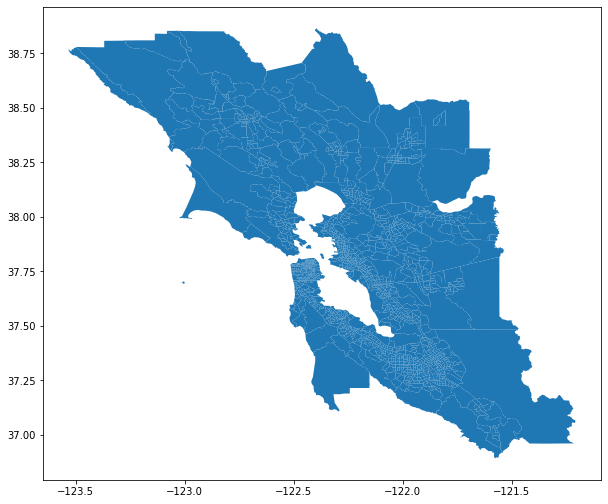

In [71]:
tracts_2018_gdf.plot(figsize=(10,10))

### Join census tracts to coc df

In [72]:
coc_tracts_pba2050 = pd.merge(
    tracts_2018_gdf, cocs_pba2050, left_on="GEOID", right_on="geoid", how="inner"
)

In [74]:
coc_tracts_pba2050['coc_2050'].sum()

339

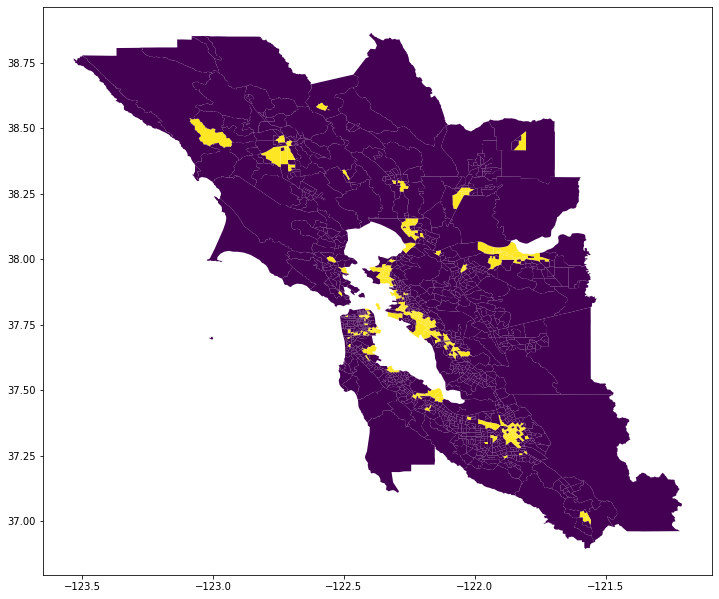

In [75]:
coc_tracts_pba2050.plot(figsize=(12, 12), column="coc_2050")

In [76]:
coc_tracts_pba2050.drop("GEOID", axis=1, inplace=True)

In [77]:
coc_tracts_pba2050.to_file("Data/COCs_ACS2018_geog.geojson", driver="GeoJSON")

### Create Field Map Dictionary to Rename Feature Class Alias

In [78]:
field_metadata = pd.read_csv("Data/COC_Schema_pba2050.csv")

In [79]:
field_metadata.head(5)

,Field Name,Alias,Data Type,ACS Calculations,ACS DefInition or COC Definition,Domain
0,geoid,Geographic ID,TEXT,NaN,Geographic Identifier,NaN
1,state,State,LONG,NaN,State ID,NaN
2,county_fip,County FIPS,DOUBLE,NaN,Federal Information Processing Standard,NaN
3,tract,Tract,TEXT,NaN,Census Tract ID,NaN
4,tot_pop,Total Population,LONG,B03002_001E,Universe: Total Population,NaN


In [80]:
dict(zip(field_metadata["Field Name"], field_metadata["Alias"]))

{'geoid': 'Geographic ID',
 'state': 'State',
 'county_fip': 'County FIPS',
 'tract': 'Tract',
 'tot_pop': 'Total Population',
 'tot_pop_po': 'Total Low Income Population',
 'tot_pop_ci': 'Total Civilian Noninstitutionalized Population',
 'tot_hh': 'Total Households',
 'tot_fam': 'Total Families',
 'tot_pop_ov': 'Total Population Over 5',
 'pop_minori': 'Population Minority',
 'pop_over75': 'Population Over 75',
 'pop_spfam': 'Population Single Parent Family',
 'pop_lep': 'Population Limited English Proficiency',
 'pop_below2': 'Population Low Income',
 'pop_disabi': 'Population Disabled',
 'pop_hus_re': 'Population Rent Burdened',
 'pop_zvhhs': 'Population Zero Vehicle Household',
 'pct_over75': 'Percent Over 75',
 'pct_minori': 'Percent Minority',
 'pct_spfam': 'Percent Single Parent Family',
 'pct_lep': 'Percent Limited English Proficiency',
 'pct_below2': 'Percent Low Income',
 'pct_disab': 'Percent Disabled',
 'pct_zvhhs': 'Percent Zero Vehicle Household',
 'pct_hus_re': 'Percent 